# Fe$_i$ in Silicon SRH Bayesian Parameter Estimation
Code to reproduce figures in [this paper](link.to.paper).

This was run in a conda environment with Python 3.6. Packages you'll need include:
* `bayesim` (the exact version used is included in this folder in case any subsequent updates have inadvertently broken anything)
* `scipy`
* `numpy` (should be automatically installed with SciPy)
* `pandas`
* `matplotlib`
* `h5py`
* `tables`
* `joblib`

Some cells will be quite slow to evaluate on a personal machine (I've tried to note these). In some places, data from large numbers of [PC1D](https://www2.pvlighthouse.com.au/resources/PC1D/PC1Dmod6/PC1Dmod6.aspx) simulations is necessary which is not obtainable without significant HPC resources. HDF5 files with these data are provided and imported.

In [6]:
import math
import numpy as np
import pandas as pd
import sys
import bayesim.model as bym
import bayesim.params as byp
from bayesim.hdf5io import load, save
import json
import os
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from scipy import constants
import h5py as h
from scipy import constants

%matplotlib inline

# font sizes for figures
axis_label_fs = 18
tick_label_fs = 16
legend_fs = 14

## Three-parameter fit (separate fits at each temperature)
First, we define the fitting parameters (and their ranges of values), experimental conditions, and output variable, along with some stuff to make the plots pretty later.

In [2]:
pl = byp.Param_list()

# fitting parameters
pl.add_fit_param(name='tau_n', val_range=[1e-11,1e-5], spacing='log', display_name=r'$\tau_n$', length=36, units='s')
pl.add_fit_param(name='tau_p', val_range=[1e-5,1e-1], spacing='log', display_name=r'$\tau_p$', length=28, units='s')
pl.add_fit_param(name='E_t', val_range=[-0.56, 0.56], display_name='$E_t$', length=28, units='eV')

# experimental conditions
pl.add_ec(name='T', display_name='temperature', units='K', tolerance=1.0)
pl.add_ec(name='ill', display_name='illumination', units='W/cm$^2$')
pl.add_ec(name='V', display_name='voltage', units='V', is_x=True, tolerance=0.001)
pl.add_output(name='J', display_name='current density', units='A/cm$^2$')

Calculating model uncertainty alone takes tens of minutes per temperature point on my laptop, so those calculation lines are commented out and the datafiles I've included with this notebook already have uncertainty included. Doing all the temperatures is still somewhat formidable on just a laptop, so we'll just do it for 300K here, but the full code is there in comments for reference, and if you want the datafiles for the other temperatures, feel free to contact me.

Even just running at 300K, this cell still takes 15 minutes or so.

**NOTE**: Before running this cell, be sure to unzip the file `3param_model_T300_withunc.h5` in this directory! (I couldn't upload it to Github normally, but compressed it's just under the 100MB limit)

In [3]:
# for all the temps
"""
T_vals = range(175,301,25)
models = {}
for T in T_vals:
    print(T)
    models[T] = bym.Model(params=pl)
    models[T].attach_observations(obs_data_path='obs_data/obs_data_T'+str(T)+'.h5', keep_all=True, verbose=True)
    #models[T].obs_data['J']=m.obs_data['J']*4.0
    #models[T].obs_data['uncertainty']=m.obs_data['uncertainty']*4.0
    models[T].attach_model(mode='file', model_data_path='sim_data_3param/T'+str(T)+'_withunc.h5', verbose=True)
    m.calc_model_unc(model_unc_factor=3.0, min_unc_val=0.00005, min_unc_frac=0.03, verbose=True)
"""

# for just 300
model = bym.Model(params=pl)
model.attach_observations(obs_data_path='obs_data_T300.h5', keep_all=True, verbose=True)
model.attach_model(mode='file', model_data_path='3param_model_T300_withunc.h5', verbose=True)

Now time for the inference! For more on what the probability mass and parameter space volume (`th_pm` and `th_pv`) parameters mean, see the [explanation on the Bayesim website](https://pv-lab.github.io/bayesim/_build/html/manual.html#performing-the-inference) or the documentation for the `run()` function itself, linked from there.

This cell takes quite awhile to run (around half an hour for me) and should produce something akin to Figure 1a from the paper.

In [ ]:
model.run(th_pm=0.9, th_pv=0.01, verbose=False)
model.visualize_probs(fpath='3param_T300_probs.png')

## Figure 1b: comparing to literature
For these we'll just load in the actual files used from the paper. First, implement a bunch of functions to get all the relationships between variables...

In [9]:
def N_C(T=300):
    num = 2 * constants.pi * 1.08 * constants.m_e * constants.k * T
    denom = (constants.h)**2
    return 2 * (num/denom)**1.5 * 1e-6 # for CGS

def N_V(T=300):
    num = 2 * constants.pi * 0.81 * constants.m_e * constants.k * T
    denom = (constants.h)**2
    return 2 * (num/denom)**1.5 * 1e-6 # for CGS

def n_i(T=300):
    Eg = 1.12 # at 300 K
    k = constants.k/constants.e
    pre = np.sqrt(N_C(T)*N_V(T))
    ex = np.exp(-Eg/(2.*k*T))
    return pre * ex

# E_t referenced from gap center to be consistent with PC1D

def n_1(E_t, T=300):
    k = constants.k/constants.e
    num = .56-E_t # E_C-E_t
    denom = k*T
    return N_C(T) * np.exp(-num/denom)

def p_1(E_t, T=300):
    k = constants.k/constants.e
    num = .56+E_t # E_t-E_V
    denom = k*T
    return N_V(T) * np.exp(-num/denom)
 
# these only work at 300 K for now because v_th is hardcoded

def tau_n(sigma_n): 
    N_t = 2.2e12
    v_th_e = 1.688e7
    return 1./(N_t*v_th_e*sigma_n)

def tau_p(sigma_p):
    N_t = 2.2e12
    v_th_h = 2.046e7
    return 1./(N_t*v_th_h*sigma_p)

def tau_SRH(delta_n, sigma_n, sigma_p, E_t, T=300):
    p_0 = 4.979e15 # doping level
    n_0 = n_i(T)**2/p_0 # detailed balance
    num = tau_n(sigma_n)*(p_0 + p_1(E_t, T) + delta_n) + tau_p(sigma_p)*(n_0 + n_1(E_t, T) + delta_n)
    denom = p_0 + n_0 + delta_n
    return num/denom

def tau_SRH_fromtaus(delta_n, tau_n, tau_p, E_t, T=300):
    p_0 = 4.979e15 # doping level
    n_0 = n_i(T)**2/p_0 # detailed balance
    num = tau_n*(p_0 + p_1(E_t, T) + delta_n) + tau_p*(n_0 + n_1(E_t, T) + delta_n)
    denom = p_0 + n_0 + delta_n
    return num/denom

# tau_n in terms of the others...for later
def tau_n_solve(tau_SRH, tau_p, delta_n, E_t, T=300):
    p_0 = 4.979e15 # doping level
    n_0 = n_i(T)**2/p_0 # detailed balance
    num_1 = tau_SRH * (p_0 + n_0 + delta_n)
    num_2 = tau_p * (n_0 + n_1(E_t) + delta_n)
    denom = p_0 + p_1(E_t) + delta_n
    return (num_1 - num_2)/denom

sigma_p_vals = [5e-17, 1e-16] # two values from Istratov's paper
sigma_n_vals = [4e-14, 3.6e-15] # one from Istratov, one from Rein/Glunz
delta_n_range = np.logspace(12,17,100)

E_t = -0.16

Then plot the simulated IDLS to compare...

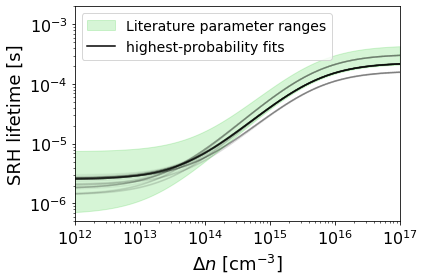

In [10]:
y = []
h = []

for sp in sigma_p_vals:
    for sn in sigma_n_vals:
        y.append([tau_SRH(dn, sn, sp, E_t) for dn in delta_n_range])
h.append(plt.fill_between(delta_n_range, y[1], y[2], alpha=0.2, color='limegreen'))
a = plt.gca()
a.set_xscale('log')
a.set_yscale('log')
plt.ylabel('SRH lifetime [s]', fontsize=axis_label_fs)
plt.xlabel('$\Delta n$ [cm$^{-3}$]', fontsize=axis_label_fs)
a.tick_params(axis='x', labelsize=tick_label_fs)
a.tick_params(axis='y', labelsize=tick_label_fs)
#plt.title('(simulated) SRH lifetime vs. injection at 300 K')
h.append(plt.plot([1e11], [1e-4], 'k')[0]) # dummy for legend

fit = load('3param_probs_300K.h5').sort_values(by='prob', ascending=False).head(80)

for row in fit.iterrows():
    tn = row[1]['tau_n']
    tp = row[1]['tau_p']
    tau_SRH_vals = [tau_SRH_fromtaus(dn, tn, tp, row[1]['E_t']) for dn in delta_n_range]
    plt.plot(delta_n_range, tau_SRH_vals, 'k', alpha=row[1].prob*8)
    
plt.legend(h[:2], ['Literature parameter ranges', 'highest-probability fits'], fontsize=legend_fs, loc='upper left')
plt.xlim([1e12, 1e17])
plt.ylim([5e-7, 2e-3])
a.set_xticks([1e12, 1e13, 1e14, 1e15, 1e16, 1e17])
minor_locs = [a * 10**p for a in range(2,10) for p in [12, 13, 14, 15, 16]]
a.set_xticks(minor_locs, minor=True)
plt.tight_layout()
#plt.savefig('SRH_comparison.png', dpi=300)
plt.show()

Figure 1c is just overlaying those curves (can calculate with `tau_SRH` function) and has a ton of finicky plotting code so I won't clutter this with it...

## Figure 2: $\sigma$ vs. $T$
Figure 2 is also pretty straightforward but requires all the data from every temperature, so it's not going to be feasible on a personal machine. For the purpose of data transparency I'll just import the numbers and plot it here.

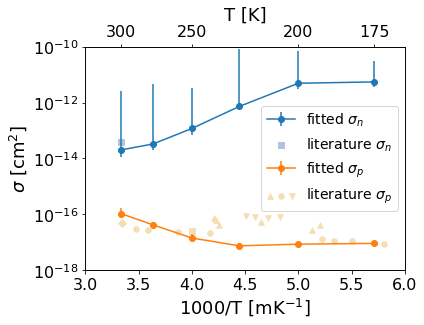

In [13]:
Istratov_data = pd.read_csv('Istratov_data.csv', header=None, names=['1000/T','sigma_h'])

T_vals = [175, 200, 225, 250, 275, 300]

# import the text data and convert to CCS
tau_n_mean = np.loadtxt('tau_data/tau_n_mean_pm9pv01.txt')
tau_p_mean = np.loadtxt('tau_data/tau_p_mean_pm9pv01.txt')
tau_n_25pct = np.loadtxt('tau_data/tau_n_25pct_pm9pv01.txt')
tau_p_25pct = np.loadtxt('tau_data/tau_p_25pct_pm9pv01.txt')
tau_n_75pct = np.loadtxt('tau_data/tau_n_75pct_pm9pv01.txt')
tau_p_75pct = np.loadtxt('tau_data/tau_p_75pct_pm9pv01.txt')

# thermal velocities from PVLighthouse: https://www.pvlighthouse.com.au/thermal-velocity
v_th_h = {175: 1.58e7, 200: 1.686e7, 225: 1.784e7, 250: 1.877e7, 275: 1.964e7, 300: 2.046e7}
v_th_e = {175: 1.277e7, 200: 1.371e7, 225: 1.458e7, 250: 1.539e7, 275: 1.615e7, 300: 1.688e7}

N_t = 2.2e12

def sigma_p(tau_p, T):
    return 1.0/(N_t * v_th_h[T] * tau_p)

def sigma_n(tau_n, T):
    return 1.0/(N_t * v_th_e[T] * tau_n)

sigma_n_mean = [sigma_n(tau_n_mean[i], T_vals[i]) for i in range(len(T_vals))]
sigma_n_low = [sigma_n(tau_n_75pct[i], T_vals[i]) for i in range(len(T_vals))]
sigma_n_high = [sigma_n(tau_n_25pct[i], T_vals[i]) for i in range(len(T_vals))]
sigma_p_mean = [sigma_p(tau_p_mean[i], T_vals[i]) for i in range(len(T_vals))]
sigma_p_low = [sigma_p(tau_p_75pct[i], T_vals[i]) for i in range(len(T_vals))]
sigma_p_high = [sigma_p(tau_p_25pct[i], T_vals[i]) for i in range(len(T_vals))]

# segment up Istratov's data by source
Lemke_1 = Istratov_data.iloc[0]
Lemke_2 = Istratov_data.iloc[1]
Gao = Istratov_data.iloc[5]
Wunstel = Istratov_data.iloc[[2,3,4,6,7,8,9,10]]
Indusekhar = Istratov_data.iloc[11:15]
Brotherton = Istratov_data.iloc[16:]

# plotting
axis_label_fs = 18
tick_label_fs = 16
legend_fs = 14

T_inv = [1000/T for T in T_vals]
#plt.scatter(T_inv, sigma_n_wt)
#plt.scatter(T_inv, sigma_p_wt)

a=plt.errorbar(T_inv, sigma_n_mean, 
             [np.array(sigma_n_mean)-np.array(sigma_n_low), np.array(sigma_n_high)-np.array(sigma_n_mean)], marker='o')
b=plt.errorbar(T_inv, sigma_p_mean, 
             [np.array(sigma_p_mean)-np.array(sigma_p_low), np.array(sigma_p_high)-np.array(sigma_p_mean)], marker='o')

#c=plt.scatter(Istratov_data['1000/T'], Istratov_data['sigma_h'], 15, 'wheat', marker='s')
# p, for legend
#c=plt.scatter(Brotherton['1000/T'], Brotherton['sigma_h'], 30, 'wheat', marker='^')

p_handles = []

# rest of p
for dat,m in zip([Brotherton, Wunstel, Indusekhar, Lemke_1, Lemke_2, Gao], ['^', 'o', 'v', 'p', 'D', 's']):
    p_handles.append(plt.scatter(dat['1000/T'], dat['sigma_h'], 30, 'wheat', marker=m))

d=plt.scatter([1000/300], [4e-14], 30, 'lightsteelblue', marker='s')

# beautifying
plt.legend([a,d,b,tuple(p_handles[:3])], ['fitted $\sigma_n$', 'literature $\sigma_n$', 'fitted $\sigma_p$', 
                               'literature $\sigma_p$'], loc='center right', fontsize=legend_fs, 
                               numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)})
plt.xlabel('1000/T [mK$^{-1}$]', fontsize=axis_label_fs)
plt.yscale('log')
plt.ylabel('$\sigma$ [cm$^2$]', fontsize=axis_label_fs)
plt.ylim(1e-18, 1e-10)
plt.xlim(3, 6)
ax1 = plt.gca()
ax1.tick_params(axis='y', labelsize=tick_label_fs)
ax1.tick_params(axis='x', labelsize=tick_label_fs)
ax2 = ax1.twiny()
ax2.set_xlim(3, 6)
ax2.set_xticks([1000./300, 1000./250, 1000./200, 1000./175])
ax2.set_xticklabels(['300', '250', '200', '175'], fontsize=tick_label_fs)
ax2.set_xlabel('T [K]', fontsize=axis_label_fs)
ax2.tick_params(axis='y', labelsize=tick_label_fs)
plt.tight_layout()
f = plt.gcf()
f.set_size_inches(6,5)
plt.show()
#plt.savefig('sigma_comparison.png', dpi=300)

# Five-parameter fit
Similarly, it's not going to be feasible to actually do the inference in this case but I include the data imports and plotting for transparency. If you want all the model, data, get in touch, but it's too big for Github.

In [14]:
# set up parameters
pl = byp.Param_list()

pl.add_fit_param(name='sigma_n_0', vals=[7.4990e-19, 1.3335e-18,
       2.3710e-18, 4.2170e-18, 7.4990e-18, 1.3335e-17, 2.3710e-17,
       4.2170e-17, 7.4990e-17, 1.3335e-16, 2.3710e-16, 4.2170e-16,
       7.4990e-16], display_name='$\sigma_{n0}$', length=16, units='cm$^2$')
#pl.add_fit_param(name='sigma_n_0', val_range=[1e-19, 1e-15], spacing='log', display_name='$\sigma_{n0}$', length=16, units='cm$^2$')
pl.add_fit_param(name='E_an', val_range=[0.15, 0.23], display_name='$E_{a,n}$', length=8, units='eV')
pl.add_fit_param(name='sigma_p_0', val_range=[1e-16, 1e-13], spacing='log', display_name='$\sigma_{p0}$', length=12, units='cm$^2$')
pl.add_fit_param(name='E_ap', val_range=[-0.12, -0.03], display_name='$E_{a,p}$', length=9, units='eV')
pl.add_fit_param(name='E_t', val_range=[-0.56, 0.4], display_name='$E_t$', length=16, units='eV')

pl.add_ec(name='T', display_name='temperature', units='K', tolerance=1.0)
pl.add_ec(name='ill', display_name='illumination', units='W/cm$^2$')
pl.add_ec(name='V', display_name='voltage', units='V', is_x=True, tolerance=0.001)
pl.add_output(name='J', display_name='current density', units='A/cm$^2$')

m = bym.Model(params=pl)
m.probs.points = load('Arr_probs_190522_pm99.h5')

pc = plt.rcParams['axes.prop_cycle']
colors = pc.by_key()['color'][:5]

Here's Figure S1, which you could crop out the $E_{\text{a,p}}$-$\sigma_{\text{p0}}$ marginalization to get Figure 3a.

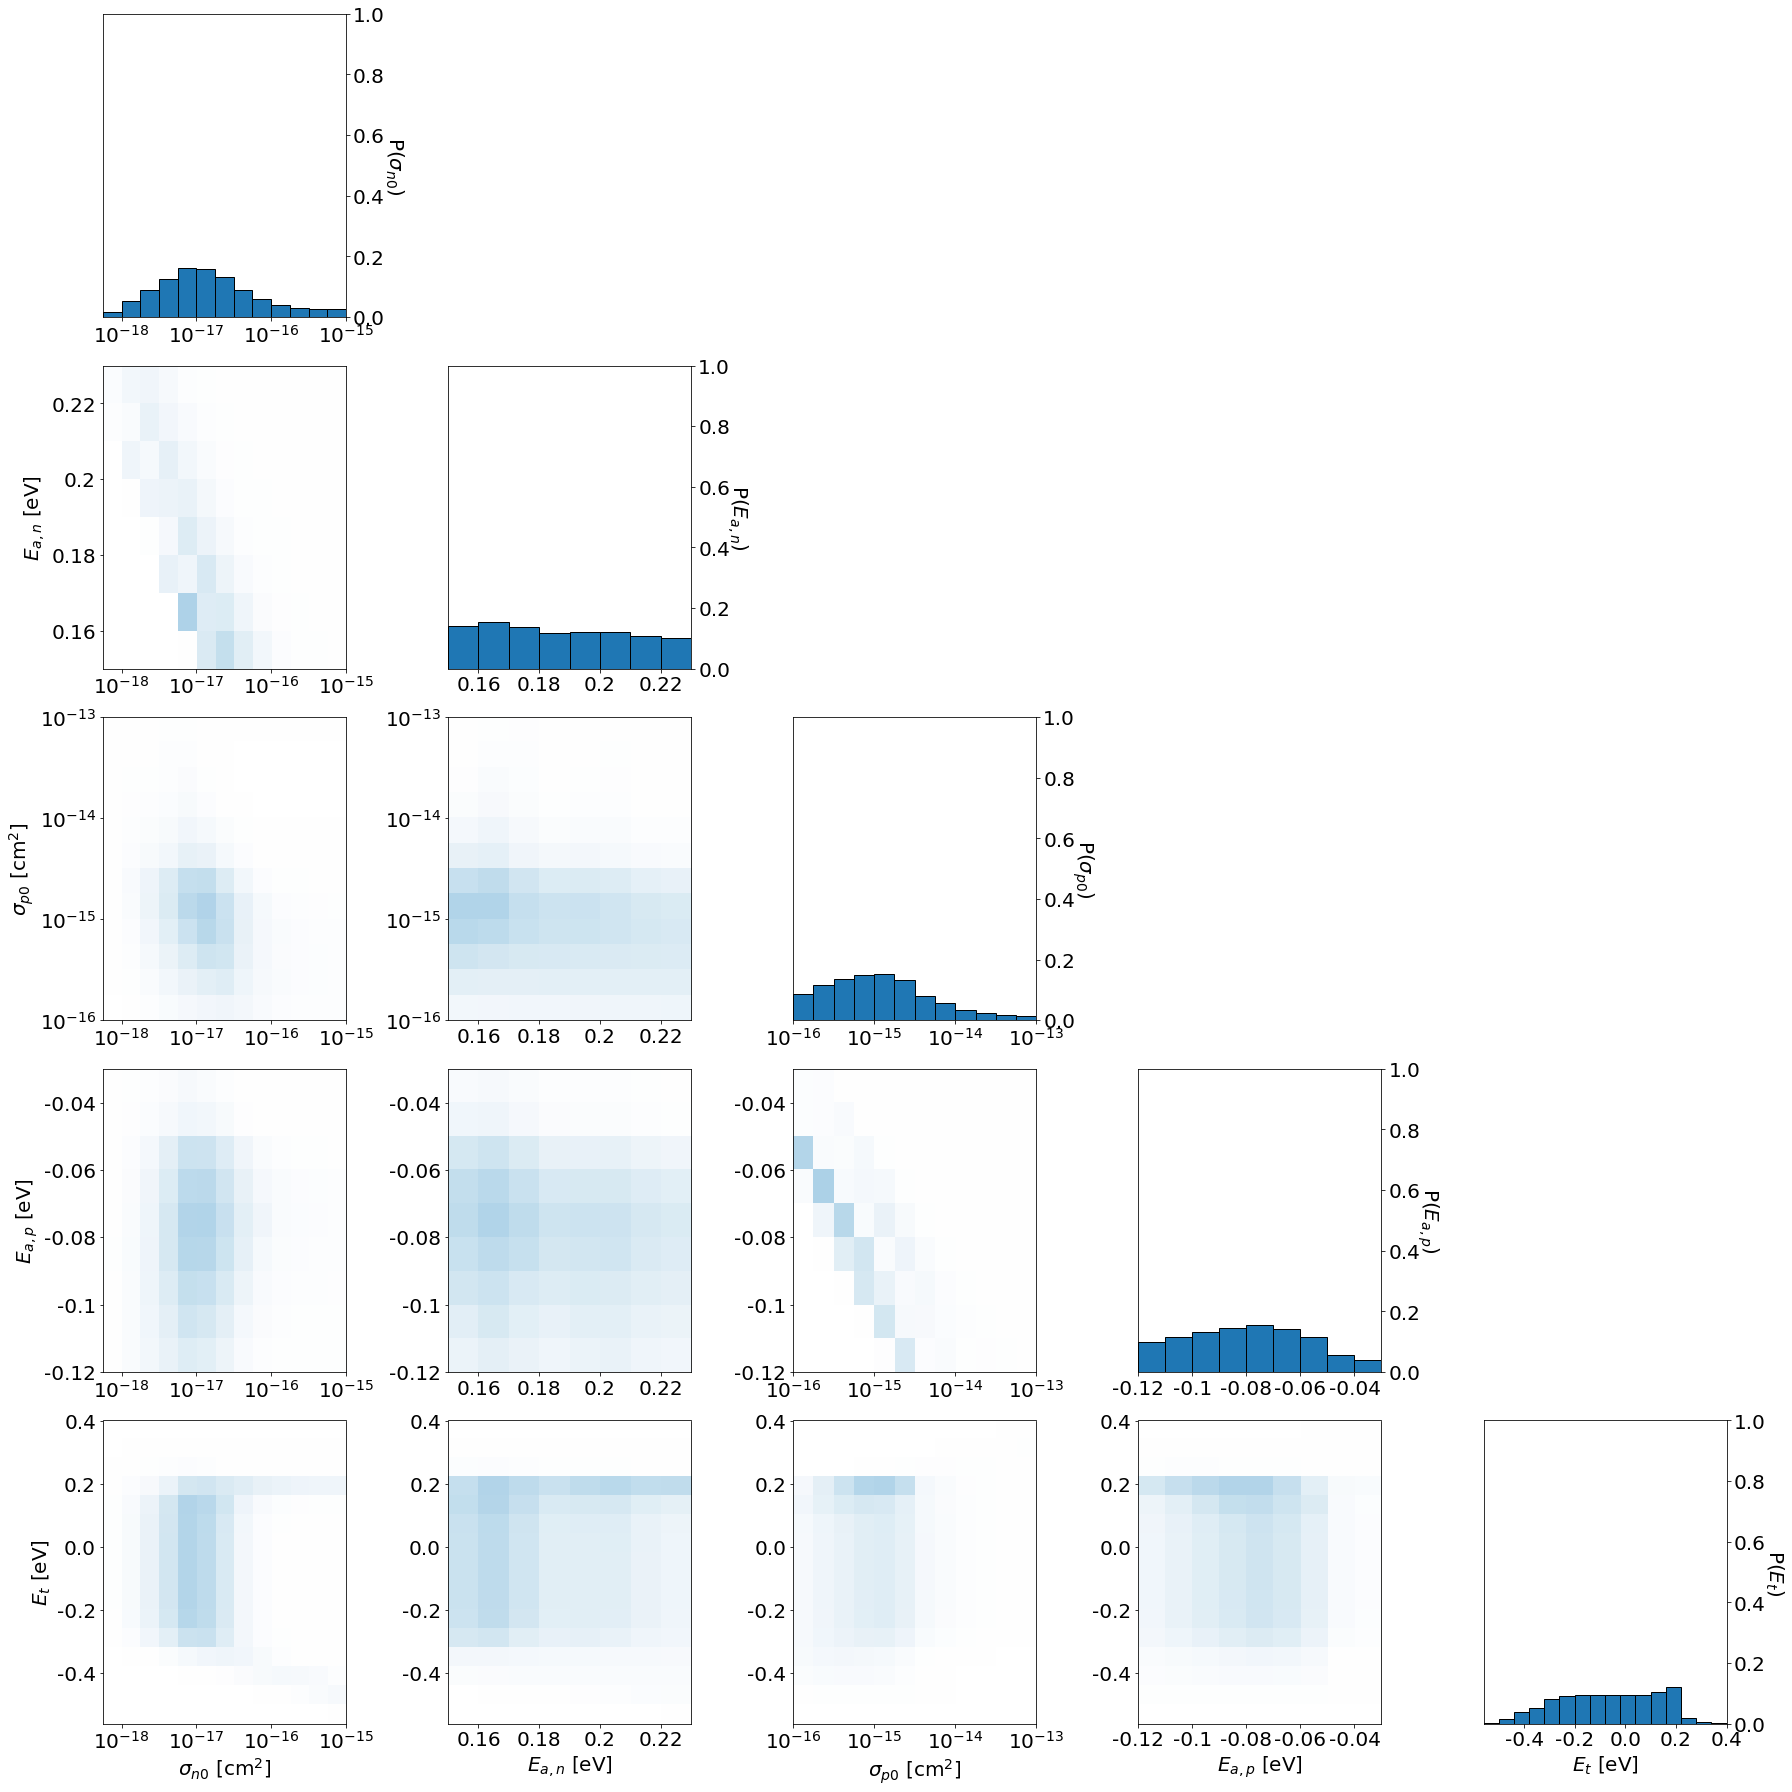

In [15]:
m.visualize_probs()

Now let's make the $\sigma_p$ vs. $T$ plots from Figure 3.

In [16]:
# first, sum up probabilities
pts_to_check = m.probs.points.drop(['sigma_n_0', 'sigma_n_0_min', 'sigma_n_0_max', 'E_an', 'E_an_min', 
                                    'E_an_max', 'E_t', 'E_t_min', 'E_t_max', 'start_ind', 'end_ind'], 
                                   axis=1).drop_duplicates(subset=['sigma_p_0', 'E_ap'])
new_data = []
for pt in pts_to_check.iterrows():
    params = dict(pt[1])
    subset = m.probs.points[m.probs.points.sigma_p_0==params['sigma_p_0']]
    subset = subset[subset.E_ap==params['E_ap']]
    params['prob'] = np.sum(subset.prob)
    new_data.append(params)
    
data = pd.DataFrame.from_records(data=new_data).sort_values(by='prob', ascending=False)

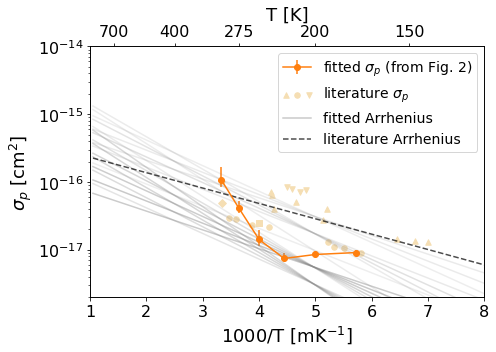

In [17]:
fig = plt.figure(figsize=[7,5])

# this is terrible practice, don't do this (rename a fcn)
def sigma_p(row):
    k = constants.k/constants.e #k_B in eV/K
    return row['sigma_p_0'] * np.exp(row['E_ap']/(k*row['T']))

T_vals_plot = np.arange(100,1000,50)
#T_vals_plot.sort
inv_T = [1000/T for T in T_vals_plot]

to_plot = data.head(20).sort_values(by='prob', ascending=True)

for pt in to_plot.iterrows():
    sigp = []
    for T in T_vals_plot:
        params = pt[1]
        params['T'] = T
        sigp.append(sigma_p(params))
    a=plt.plot(inv_T, sigp, color='gray', alpha=params.prob*8)

Istratov_params = {'sigma_p_0': 3.9e-16, 'E_ap': -0.045}
sigp = []
for T in T_vals_plot:
    Istratov_params['T'] = T
    sigp.append(sigma_p(Istratov_params))
d=plt.plot(inv_T, sigp, color='k', linestyle='--', alpha=0.7)

T_vals = [175, 200, 225, 250, 275, 300]
T_inv = [1000/T for T in T_vals]

b=plt.errorbar(T_inv, sigma_p_mean, 
             [np.array(sigma_p_mean)-np.array(sigma_p_low), np.array(sigma_p_high)-np.array(sigma_p_mean)], 
               marker='o', color='tab:orange')
#c=plt.scatter(Istratov_data['1000/T'], Istratov_data['sigma_h'], 15, 'wheat', marker='s', edgecolors='face')
  
    
p_handles = []

# rest of p
for dat,m in zip([Brotherton, Wunstel, Indusekhar, Lemke_1, Lemke_2, Gao], ['^', 'o', 'v', 'p', 'D', 's']):
    p_handles.append(plt.scatter(dat['1000/T'], dat['sigma_h'], 30, 'wheat', marker=m))
    
plt.yscale('log')
plt.ylim([2e-18,5e-15])

ax = plt.gca()
ax.set_xlim([1,8])
ax.set_ylim([2e-18, 1e-14])
ax2 = ax.twiny()
ax2.set_xlim(1, 8)
ax2.set_xticks([1000./700, 1000./400, 1000./275, 1000./200, 1000./150])
ax2.set_xticklabels(['700', '400', '275', '200', '150'], fontsize=tick_label_fs)
ax2.set_xlabel('T [K]', fontsize=axis_label_fs)

plt.legend([b, tuple(p_handles[:3]), a[0], d[0]],['fitted $\sigma_p$ (from Fig. 2)', 'literature $\sigma_p$', 'fitted Arrhenius', 
                               'literature Arrhenius'], fontsize=legend_fs, numpoints=1, 
                               handler_map={tuple: HandlerTuple(ndivide=None)})
ax.set_xlabel('1000/T [mK$^{-1}$]', fontsize=axis_label_fs)
ax.set_ylabel('$\sigma_p$ [cm$^2$]', fontsize=axis_label_fs)
ax.tick_params(axis='x', labelsize=tick_label_fs)
ax.tick_params(axis='y', labelsize=tick_label_fs)

plt.tight_layout()
plt.show()
#plt.savefig('Arrhenius_fits.png', dpi=300)

Now condition the distribution on $E_{\text{a,p}}$...

In [26]:
probs = load('Arr_probs_190522_pm99.h5')
inds = probs[probs.E_ap<-0.06].index
new_prob = deepcopy(probs.prob)
for i in inds:
    new_prob[i] = 0.0
norm = np.sum(new_prob)
new_prob = new_prob/norm
probs.prob = new_prob

m = bym.Model(params=pl)
m.probs.points = probs

We can check what the distribution looks like now...

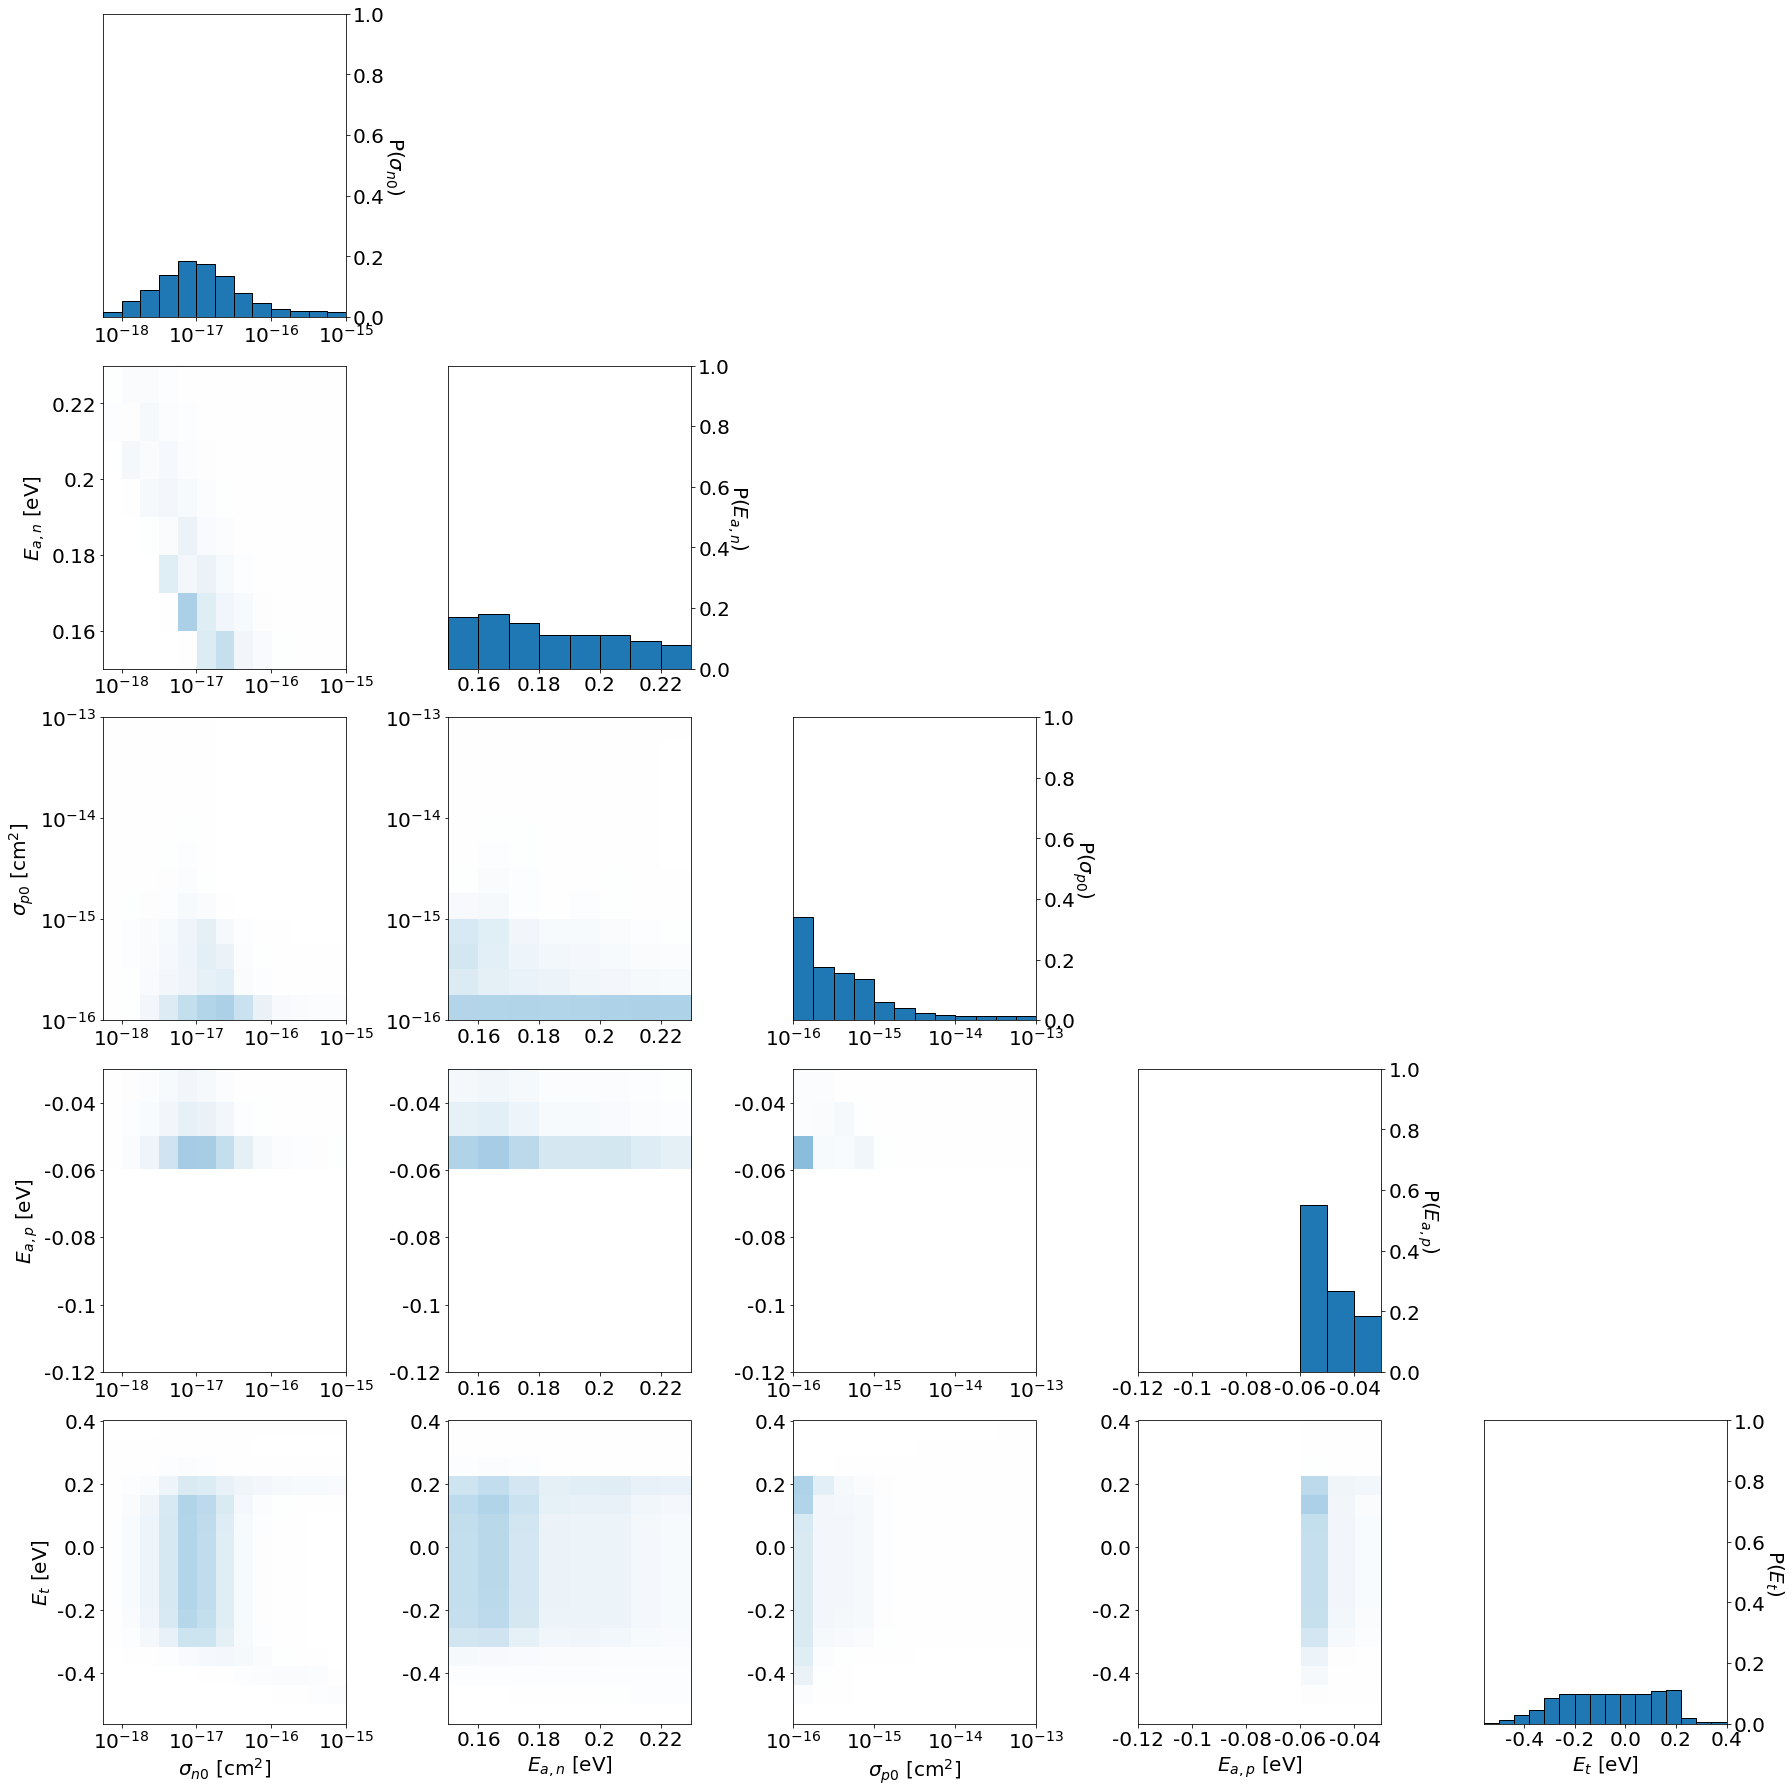

In [21]:
m.visualize_probs()

In [22]:
# first, sum up probabilities
pts_to_check = m.probs.points.drop(['sigma_n_0', 'sigma_n_0_min', 'sigma_n_0_max', 'E_an', 'E_an_min', 
                                    'E_an_max', 'E_t', 'E_t_min', 'E_t_max', 'start_ind', 'end_ind'], 
                                   axis=1).drop_duplicates(subset=['sigma_p_0', 'E_ap'])

new_data = []
for pt in pts_to_check.iterrows():
    params = dict(pt[1])
    subset = m.probs.points[m.probs.points.sigma_p_0==params['sigma_p_0']]
    subset = subset[subset.E_ap==params['E_ap']]
    params['prob'] = np.sum(subset.prob)
    new_data.append(params)
    
data = pd.DataFrame.from_records(data=new_data).sort_values(by='prob', ascending=False)

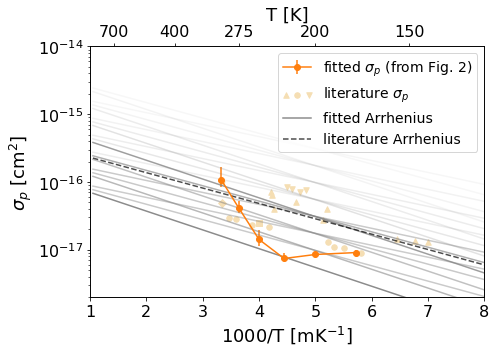

In [23]:
fig = plt.figure(figsize=[7,5])

# this is terrible practice, don't do this (rename a fcn)
def sigma_p(row):
    k = constants.k/constants.e #k_B in eV/K
    return row['sigma_p_0'] * np.exp(row['E_ap']/(k*row['T']))

T_vals_plot = np.arange(100,1000,50)
#T_vals_plot.sort
inv_T = [1000/T for T in T_vals_plot]

to_plot = data.head(20).sort_values(by='prob', ascending=True)

for pt in to_plot.iterrows():
    sigp = []
    for T in T_vals_plot:
        params = pt[1]
        params['T'] = T
        sigp.append(sigma_p(params))
    a=plt.plot(inv_T, sigp, color='gray', alpha=params.prob*8)

Istratov_params = {'sigma_p_0': 3.9e-16, 'E_ap': -0.045}
sigp = []
for T in T_vals_plot:
    Istratov_params['T'] = T
    sigp.append(sigma_p(Istratov_params))
d=plt.plot(inv_T, sigp, color='k', linestyle='--', alpha=0.7)

T_vals = [175, 200, 225, 250, 275, 300]
T_inv = [1000/T for T in T_vals]

b=plt.errorbar(T_inv, sigma_p_mean, 
             [np.array(sigma_p_mean)-np.array(sigma_p_low), np.array(sigma_p_high)-np.array(sigma_p_mean)], 
               marker='o', color='tab:orange')
#c=plt.scatter(Istratov_data['1000/T'], Istratov_data['sigma_h'], 15, 'wheat', marker='s', edgecolors='face')
  
p_handles = []

# rest of p
for dat,m in zip([Brotherton, Wunstel, Indusekhar, Lemke_1, Lemke_2, Gao], ['^', 'o', 'v', 'p', 'D', 's']):
    p_handles.append(plt.scatter(dat['1000/T'], dat['sigma_h'], 30, 'wheat', marker=m))
    
plt.yscale('log')
plt.ylim([2e-18,5e-15])

ax = plt.gca()
ax.set_xlim([1,8])
ax.set_ylim([2e-18, 1e-14])
ax2 = ax.twiny()
ax2.set_xlim(1, 8)
ax2.set_xticks([1000./700, 1000./400, 1000./275, 1000./200, 1000./150])
ax2.set_xticklabels(['700', '400', '275', '200', '150'], fontsize=tick_label_fs)
ax2.set_xlabel('T [K]', fontsize=axis_label_fs)

plt.legend([b, tuple(p_handles[:3]), a[0], d[0]],['fitted $\sigma_p$ (from Fig. 2)', 'literature $\sigma_p$', 'fitted Arrhenius', 
                               'literature Arrhenius'], fontsize=legend_fs, numpoints=1, 
                               handler_map={tuple: HandlerTuple(ndivide=None)})
ax.set_xlabel('1000/T [mK$^{-1}$]', fontsize=axis_label_fs)
ax.set_ylabel('$\sigma_p$ [cm$^2$]', fontsize=axis_label_fs)
ax.tick_params(axis='x', labelsize=tick_label_fs)
ax.tick_params(axis='y', labelsize=tick_label_fs)

plt.tight_layout()
plt.show()
#plt.savefig('Arrhenius_fits_conditioned.png', dpi=300)

Incidentally, as a bonus, we can also plot the simulated lifetime spectroscopy for the 5-parameter fit too, and it looks even better than the 3-parameter version!

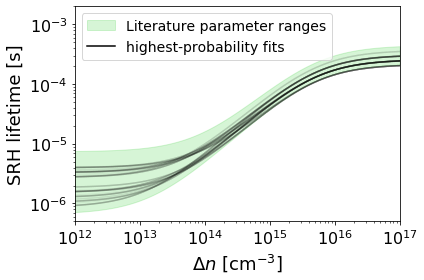

In [31]:
E_t = -0.16

y = []
h = []

for sp in sigma_p_vals:
    for sn in sigma_n_vals:
        y.append([tau_SRH(dn, sn, sp, E_t) for dn in delta_n_range])
h.append(plt.fill_between(delta_n_range, y[1], y[2], alpha=0.2, color='limegreen'))
a = plt.gca()
a.set_xscale('log')
a.set_yscale('log')
plt.ylabel('SRH lifetime [s]', fontsize=axis_label_fs)
plt.xlabel('$\Delta n$ [cm$^{-3}$]', fontsize=axis_label_fs)
a.tick_params(axis='x', labelsize=tick_label_fs)
a.tick_params(axis='y', labelsize=tick_label_fs)
#plt.title('(simulated) SRH lifetime vs. injection at 300 K')
h.append(plt.plot([1e11], [1e-4], 'k')[0]) # dummy for legend

fit = load('params_plot.h5').head(80)

for row in fit.iterrows():
    sn = row[1]['sigma_n_0'] * np.exp(row[1]['E_an']/.0257)
    sp = row[1]['sigma_p_0'] * np.exp(row[1]['E_ap']/.0257)
    tau_SRH_vals = [tau_SRH(dn, sn, sp, row[1]['E_t']) for dn in delta_n_range]
    plt.plot(delta_n_range, tau_SRH_vals, 'k', alpha=row[1].prob*200)

plt.legend(h[:2], ['Literature parameter ranges', 'highest-probability fits'], fontsize=legend_fs, loc='upper left')
plt.xlim([1e12, 1e17])
plt.ylim([5e-7, 2e-3])
a.set_xticks([1e12, 1e13, 1e14, 1e15, 1e16, 1e17])
minor_locs = [a * 10**p for a in range(2,10) for p in [12, 13, 14, 15, 16]]
a.set_xticks(minor_locs, minor=True)
plt.tight_layout()
#plt.savefig('SRH_comparison_5param.png', dpi=300)
plt.show()